In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('/content/BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].replace({',':''},regex=True).apply(pd.to_numeric)
df['Open'] = df['Open'].replace({',':''},regex=True).apply(pd.to_numeric)
df['High'] = df['High'].replace({',':''},regex=True).apply(pd.to_numeric)
df['Low'] = df['Low'].replace({',':''},regex=True).apply(pd.to_numeric)
df = df[['Date','Price']]
df = df.set_index('Date')
df.head()

,Price
Date,
2021-05-19,38678.4
2021-05-18,42897.3
2021-05-17,43541.3
2021-05-16,46426.4
2021-05-15,46708.8


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,3959.0,4628.089972,9637.641401,0.1,79.45,573.9,6643.1,63540.9


In [4]:
df = df[:1000]
df.head()

,Price
Date,
2021-05-19,38678.4
2021-05-18,42897.3
2021-05-17,43541.3
2021-05-16,46426.4
2021-05-15,46708.8


### Split the Data

In [5]:
column_indices = {name:i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean ) / train_std

### Data Windowing

In [7]:
class WindowGenerator:
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_column_indices = {name: i for i,name in enumerate(label_columns)}
    self.column_indices = {name: i for i,name in enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


In [8]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Price'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Price']

In [9]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Price'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Price']

In [10]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
labels shape: (3, 1, 1)


### Plot

In [11]:
w2.example = example_inputs, example_labels

In [12]:
def plot(self, model=None, plot_col='Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_column_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

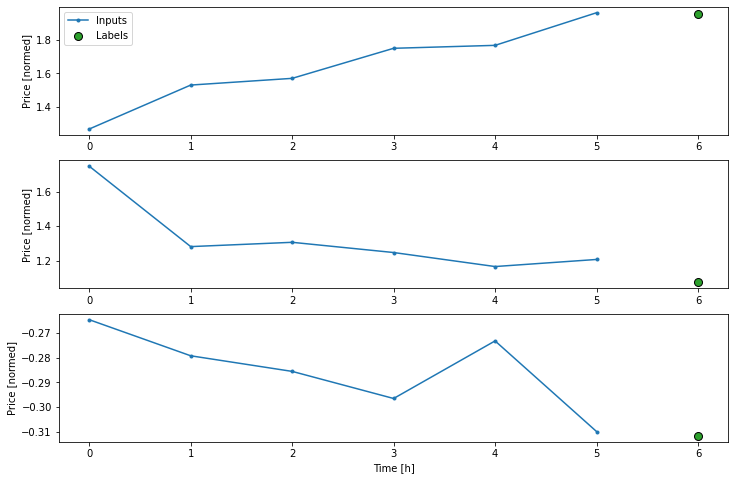

In [13]:
w2.plot()

### Create tf.data.Datasets

In [14]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length = self.total_window_size,
      sequence_stride = 1,
      shuffle=True,
      batch_size=32
  )

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result

  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [17]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Single Step models

In [18]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Price']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Price']

In [19]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

In [20]:
class Baseline(tf.keras.Model):

  def __init__(self,label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:,:,self.label_index]
    return result[:,:,tf.newaxis]

In [21]:
baseline = Baseline(label_index=column_indices['Price'])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

7/7 [==============================] - 0s 3ms/step - loss: 1.2982e-04 - mean_absolute_error: 0.0071


In [22]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['Price']
)

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Price']

In [23]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


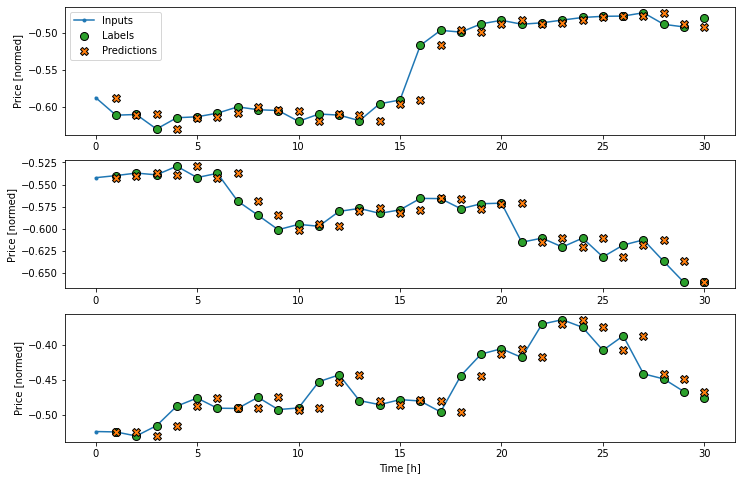

In [24]:
wide_window.plot(baseline)

### Linear model

In [25]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [26]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [27]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [28]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
22/22 [==============================] - 1s 29ms/step - loss: 5.6721 - mean_absolute_error: 1.8547 - val_loss: 3.3908 - val_mean_absolute_error: 1.8255
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 5.1846 - mean_absolute_error: 1.7743 - val_loss: 3.3274 - val_mean_absolute_error: 1.8083
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 4.8766 - mean_absolute_error: 1.7239 - val_loss: 3.2609 - val_mean_absolute_error: 1.7901
Epoch 4/20
22/22 [==============================] - 0s 10ms/step - loss: 5.0136 - mean_absolute_error: 1.7371 - val_loss: 3.2014 - val_mean_absolute_error: 1.7737
Epoch 5/20
22/22 [==============================] - 0s 10ms/step - loss: 4.8531 - mean_absolute_error: 1.7084 - val_loss: 3.1430 - val_mean_absolute_error: 1.7575
Epoch 6/20
22/22 [==============================] - 0s 18ms/step - loss: 4.7603 - mean_absolute_error: 1.6900 - val_loss: 3.0791 - val_mean_absolute_error: 1.7395
Epoch 7/20
22/22 [====

In [29]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


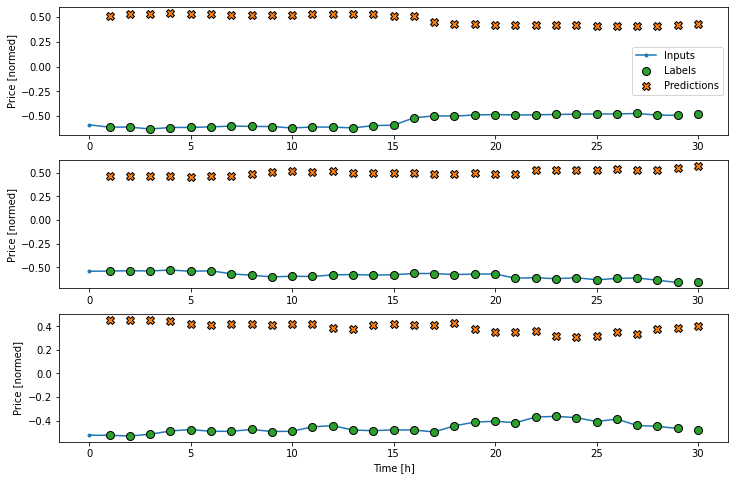

In [30]:
wide_window.plot(linear)

### Dense

In [31]:
dense = tf.keras.Sequential([
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(1),
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
22/22 [==============================] - 1s 22ms/step - loss: 0.5904 - mean_absolute_error: 0.5944 - val_loss: 0.1046 - val_mean_absolute_error: 0.3186
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0384 - mean_absolute_error: 0.1336 - val_loss: 0.0016 - val_mean_absolute_error: 0.0372
Epoch 3/20
22/22 [==============================] - 0s 12ms/step - loss: 0.0080 - mean_absolute_error: 0.0557 - val_loss: 0.0034 - val_mean_absolute_error: 0.0536
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0591


In [32]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Price']
)
conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

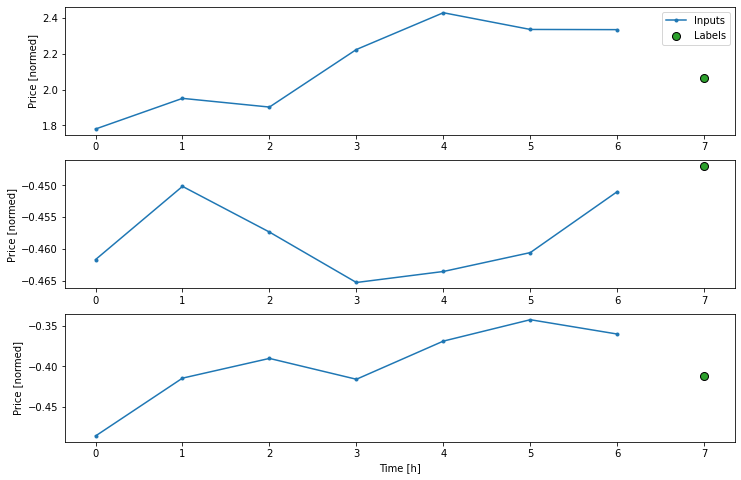

In [33]:
conv_window.plot()

In [34]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1,-1])
])

In [35]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 7, 1)
Output shape: (32, 1, 1)


In [36]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
22/22 [==============================] - 1s 16ms/step - loss: 0.1222 - mean_absolute_error: 0.3079 - val_loss: 0.0085 - val_mean_absolute_error: 0.0888
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0071 - mean_absolute_error: 0.0581 - val_loss: 0.0017 - val_mean_absolute_error: 0.0380
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0070 - mean_absolute_error: 0.0503 - val_loss: 0.0027 - val_mean_absolute_error: 0.0489
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0398


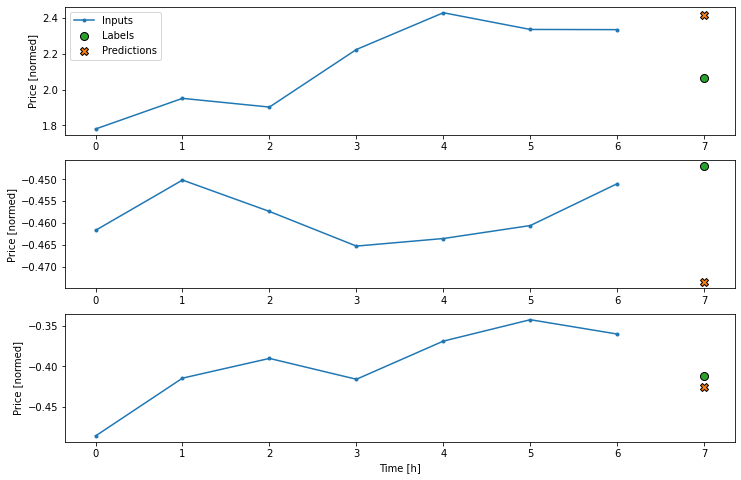

In [37]:
conv_window.plot(multi_step_dense)

### Convolution neural network

In [38]:
conv_model = tf.keras.Sequential([
     tf.keras.layers.Conv1D(32,kernel_size=(CONV_WIDTH,),
                            activation='relu'),
     tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(1)                             
])

In [39]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 7, 1)
Output shape: (32, 1, 1)


In [40]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

7/7 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0405


In [41]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 30, 1)
Labels shape: (32, 30, 1)
Output shape: (32, 24, 1)


In [42]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Price']
)

wide_conv_window

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36]
Label column name(s): ['Price']

In [43]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 36, 1)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


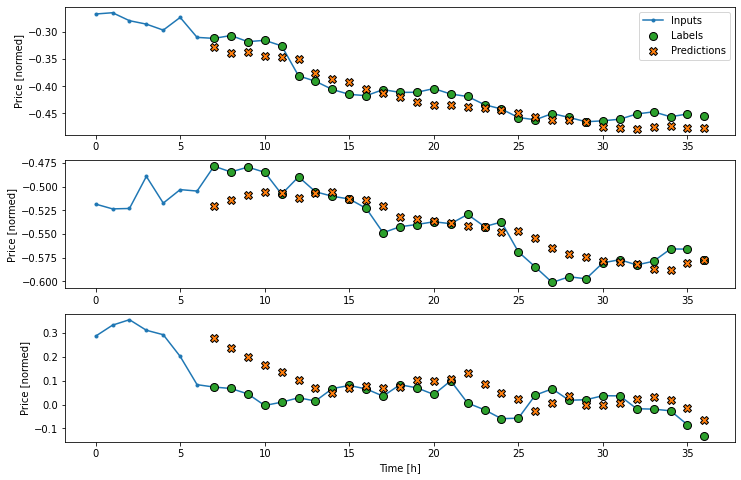

In [44]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network

In [45]:
lstm_model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(32,return_sequences=True),
     tf.keras.layers.Dense(1)                                    
])

In [46]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


In [47]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

6/6 [==============================] - 0s 5ms/step - loss: 0.0136 - mean_absolute_error: 0.0589


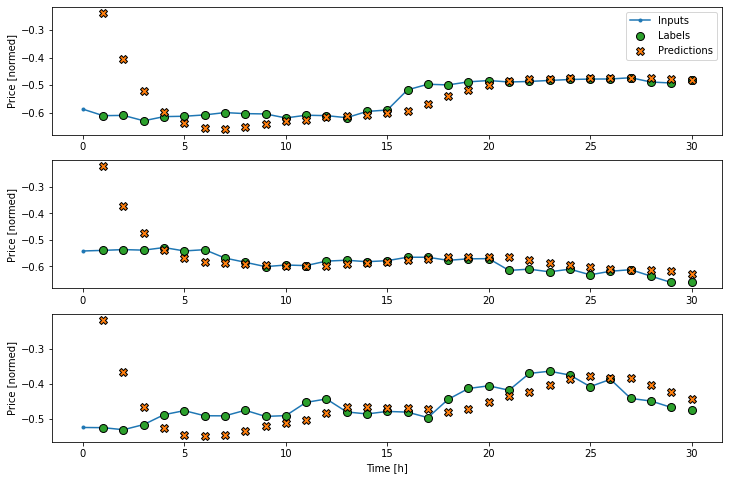

In [48]:
wide_window.plot(lstm_model)

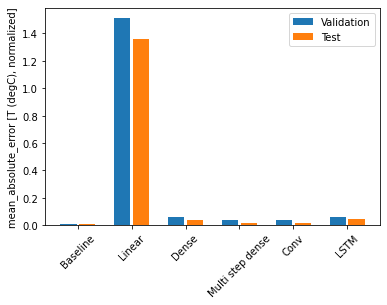

In [49]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [50]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0065
Linear      : 1.3605
Dense       : 0.0373
Multi step dense: 0.0176
Conv        : 0.0179
LSTM        : 0.0471


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

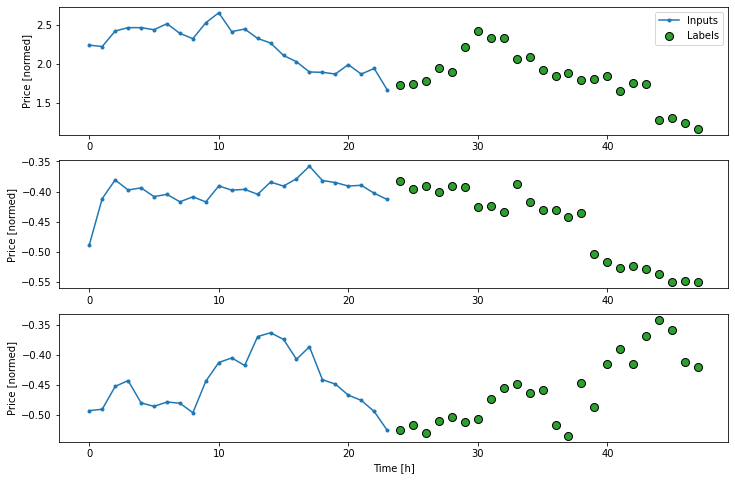

In [51]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Multi-step models

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36]
Label column name(s): None

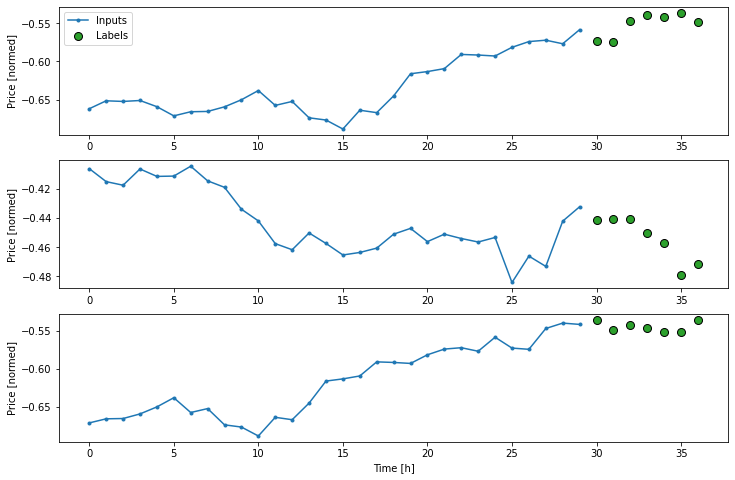

In [52]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=30,
                               label_width = OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

6/6 [==============================] - 0s 4ms/step - loss: 4.2160e-04 - mean_absolute_error: 0.0118


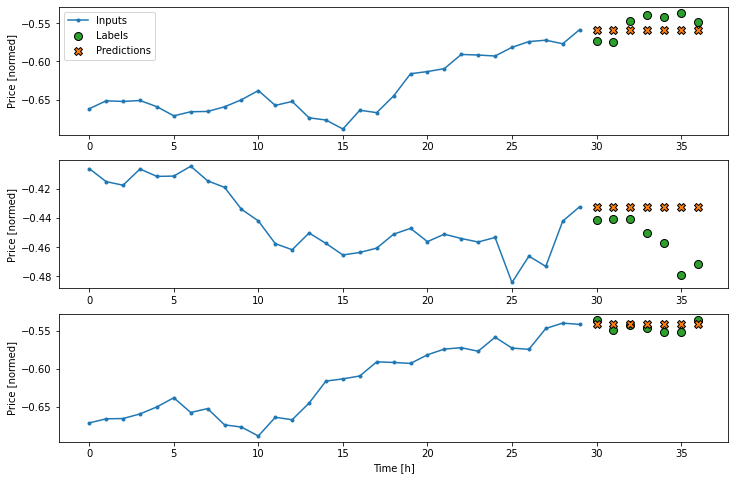

In [53]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :],[1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

### Single Shot Model

Linear

6/6 [==============================] - 0s 3ms/step - loss: 0.2253 - mean_absolute_error: 0.4731


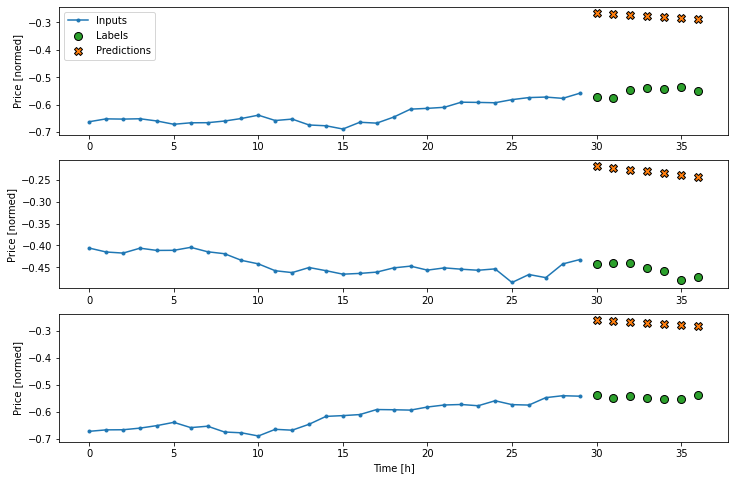

In [54]:
multi_linear_model = tf.keras.Sequential([
       tf.keras.layers.Lambda(lambda x:x[:, -1, :]),
       tf.keras.layers.Dense(OUT_STEPS*num_features,
                             kernel_initializer=tf.initializers.zeros()),
       tf.keras.layers.Reshape([OUT_STEPS, num_features])                                   
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Dense

6/6 [==============================] - 0s 3ms/step - loss: 0.0140 - mean_absolute_error: 0.1159


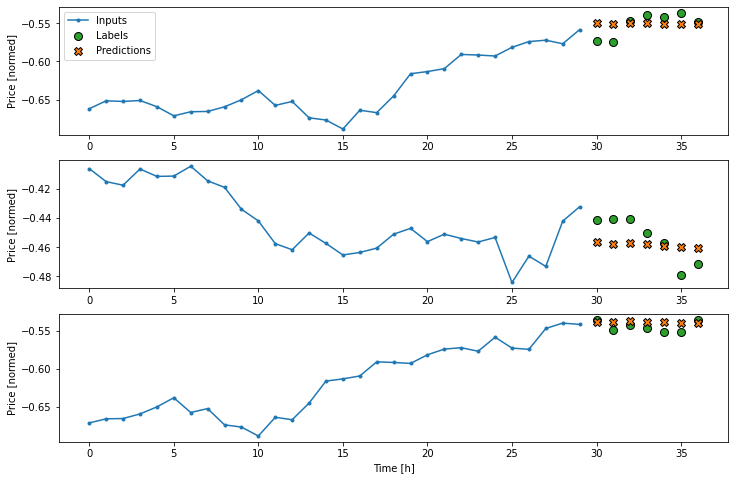

In [55]:
multi_dense_model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: x[:,-1,:]),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([OUT_STEPS, num_features])                                 
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

CNN

6/6 [==============================] - 0s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0802


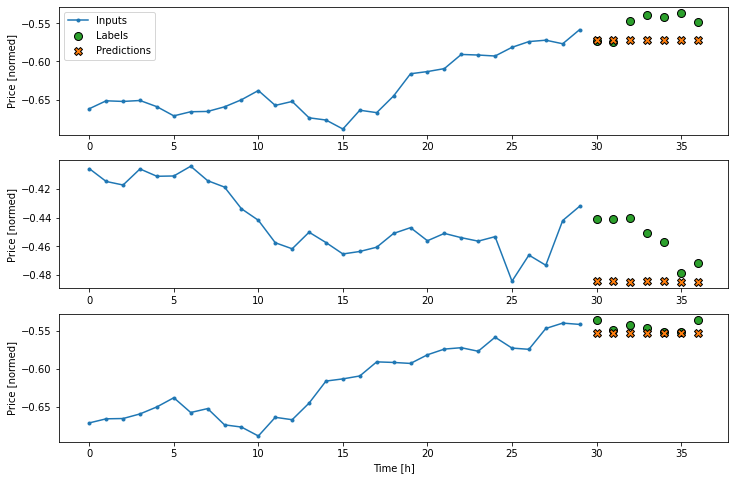

In [56]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
         tf.keras.layers.Lambda(lambda x: x[:,-CONV_WIDTH:, :]),
         tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
         tf.keras.layers.Dense(OUT_STEPS*num_features,
                               kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([OUT_STEPS, num_features])                               
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

RNN

6/6 [==============================] - 0s 5ms/step - loss: 0.1074 - mean_absolute_error: 0.3230


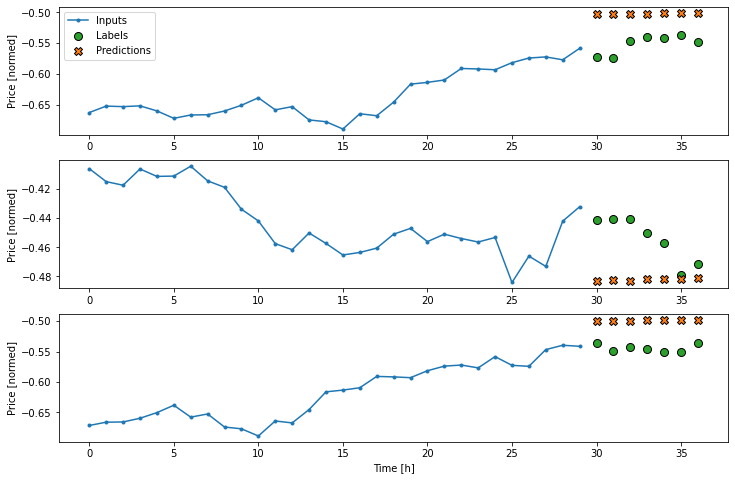

In [57]:
multi_lstm_model = tf.keras.Sequential([
       tf.keras.layers.LSTM(32, return_sequences=False),
       tf.keras.layers.Dense(OUT_STEPS*num_features,
                             kernel_initializer=tf.initializers.zeros()),
       tf.keras.layers.Reshape([OUT_STEPS, num_features])                                 
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Auto-regressive RNN model

In [58]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
  
  def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)

    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)

    predictions.append(prediction)

    for n in range(1, self.out_steps):
      x = prediction
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      prediction = self.dense(x)
      predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1,0,2])
    return predictions


6/6 [==============================] - 0s 8ms/step - loss: 0.0520 - mean_absolute_error: 0.2241


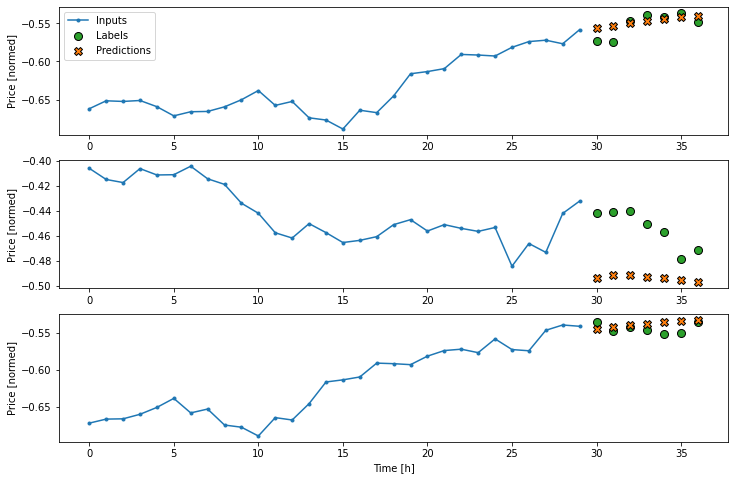

In [59]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

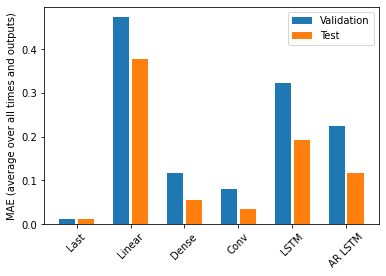

In [60]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()